In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import gensim
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_

import warnings
warnings.filterwarnings("ignore")

C:\Anaconda\anaconda3\envs\Senti\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(1.0, 0)  # Limits to 50% of GPU memory

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
df = pd.read_csv("reviews.csv")

In [4]:
def preprocess_text(text):
    if isinstance(text, str):  
        text = re.sub(r"[^a-zA-Z\s]", "", text.lower()) 
        text = re.sub(r"\s+", " ", text).strip()  
        return text
    return ""  

df['text'] = df['text'].apply(preprocess_text)


In [5]:
assert df['rating'].min() == 1 and df['rating'].max() == 5

In [6]:
df.isna().sum()

rating    766878
text           0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.isna().sum()

rating    0
text      0
dtype: int64

In [9]:
df

,rating,text
0,4.0,im playing on ps and its interesting its uniqu...
1,5.0,nostalgic fun a bit slow i hope they dont stre...
2,5.0,this was an order for my kids they have really...
3,5.0,these work great they use batteries which is a...
4,5.0,i would recommend to anyone looking to add jus...
...,...,...
205459,1.0,these cables do not last at all ive been throu...
205460,5.0,i like it
205461,5.0,love it
205462,3.0,ok


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['rating'], test_size=0.2, random_state=42, stratify=df['rating']
)

In [11]:
def train_word2vec(texts, vector_size=100, window=5, min_count=2, epochs=30):
    tokenized_texts = [text.split() for text in texts]
    model = gensim.models.Word2Vec(
        sentences=tokenized_texts, vector_size=vector_size, window=window, min_count=min_count, workers=4
    )
    model.train(tokenized_texts, total_examples=len(tokenized_texts), epochs=epochs)
    return model

In [12]:
word2vec_model = train_word2vec(X_train)

In [13]:
vectorizer = CountVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Train and evaluate a baseline Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_preds = nb_model.predict(X_test_vec)

In [14]:
print("Naive Bayes Metrics:")
accuracy = accuracy_score(y_test, nb_preds)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, nb_preds, average='weighted')
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Naive Bayes Metrics:
Accuracy: 0.6820, Precision: 0.6399, Recall: 0.6820, F1 Score: 0.6538


In [15]:
print(X_train.head())  # Display first few rows of texts
print(y_train.head())  # Display first few rows of labels

27543     game is alright but it takes a lot of time to ...
132596    if you have played lego games in the past then...
23616     this case is plenty sturdy with a foam cutout ...
13483     feels fantastic and really upped my osu gaming...
128235    these are an okay pair of budget headphones bu...
Name: text, dtype: object
27543     3.0
132596    4.0
23616     5.0
13483     4.0
128235    2.0
Name: rating, dtype: float64


In [16]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        try:
            text = self.texts.iloc[item]  # .iloc for pandas series
            label = self.labels.iloc[item]  # .iloc for pandas series
        except KeyError as e:
            print(f"KeyError: {e} - Invalid index: {item}")
            raise

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 64  # Increase max length
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 3e-5  # Slightly higher learning rate
ACCUMULATION_STEPS = 4

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [19]:
y_train = y_train - 1  # If the labels are in the range 1-5, shift to 0-4.
y_test = y_test - 1
train_dataset = SentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = SentimentDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
unique_labels = np.unique(y_train)
print(unique_labels)


[0. 1. 2. 3. 4.]


In [21]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.array([0,1, 2, 3, 4]), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=5)  # 5 classes (1-5)
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [24]:
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

In [25]:
from tqdm import tqdm

def train_model(model, data_loader, optimizer, scheduler, device, loss_fn):
    model.train()
    loop = tqdm(data_loader, desc="Training", leave=True)
    optimizer.zero_grad()

    for step, batch in enumerate(loop):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # Standard loss calculation
        loss = loss / ACCUMULATION_STEPS  # Normalize loss for gradient accumulation

        # Backward pass
        loss.backward()

        # Gradient accumulation and optimization
        if (step + 1) % ACCUMULATION_STEPS == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        loop.set_postfix(loss=loss.item())

# Use the class-weighted loss during training
train_model(model, train_loader, optimizer, scheduler, device, loss_fn)


Training: 100%|██████████| 10274/10274 [20:09<00:00,  8.49it/s, loss=0.296] 


In [26]:
def evaluate_model(model, data_loader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    all_actual_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

            # Store actual and predicted labels
            all_actual_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(preds.cpu().numpy())

    accuracy = correct_predictions / total_predictions
    return accuracy, all_actual_labels, all_predicted_labels

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*EPOCHS)
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_model(model, data_loader, optimizer, scheduler, device)


In [27]:
accuracy, bert_actual,bert_preds = evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 2569/2569 [02:16<00:00, 18.88it/s]


In [28]:
bert_actual = [pred - 1 for pred in bert_actual]
bert_accuracy = accuracy_score(bert_actual, bert_preds)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(bert_actual, bert_preds, average='weighted')



In [29]:
print("BERT Metrics:")
print(f"Accuracy: {bert_accuracy:.4f}, Precision: {bert_precision:.4f}, Recall: {bert_recall:.4f}, F1 Score: {bert_f1:.4f}")

BERT Metrics:
Accuracy: 0.0785, Precision: 0.2682, Recall: 0.0785, F1 Score: 0.1045


BERT Confusion Matrix:


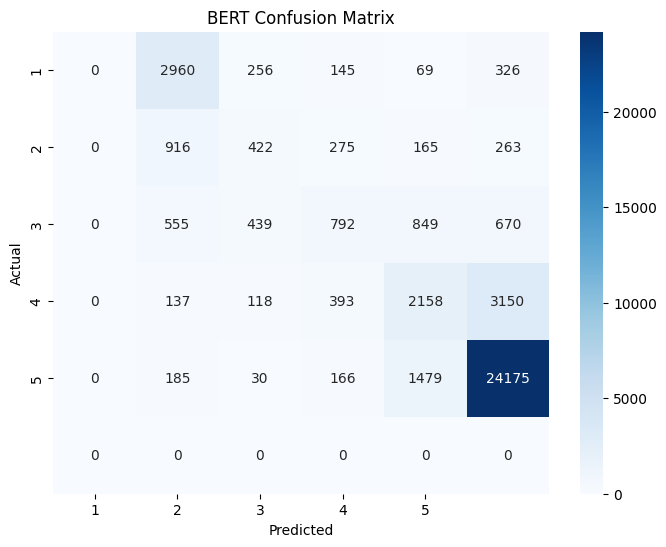

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

print("BERT Confusion Matrix:")
plot_confusion_matrix(bert_actual, bert_preds, model_name="BERT")


In [33]:
def predict_review(model, tokenizer, review, max_len, device):
    # Preprocess the review text
    review = preprocess_text(review)
    
    encoding = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

    # Map prediction to class (e.g., 1-5)
    return preds.item() + 1  

# Ask user for a review input
user_review = input("Please enter your review: ")

review_class = predict_review(model, tokenizer, user_review, MAX_LEN, device)

print(f"The review is classified as: {review_class}")


Please enter your review:  I didn't like the film very much


The review is classified as: 2
